In [1]:
# ============================================
# Load python scripts
# ============================================
import sys
sys.path.append('/kaggle/input/meansparse')
import Meansparse_wrn_94_16

In [2]:
# ============================================
# Install dependencies
# ============================================
!pip install -q huggingface_hub captum

In [3]:
# ============================================
# Import libraries
# ============================================
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset, Subset, WeightedRandomSampler
from torchsummary import summary
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from PIL import ImageFile, Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import gc
from huggingface_hub import HfApi, login, create_repo, hf_hub_download
from kaggle_secrets import UserSecretsClient
import Meansparse_wrn_94_16
from Meansparse_wrn_94_16 import MeanSparse_DMWideResNet
import json
from torch.utils.data import Dataset
from captum.attr import IntegratedGradients
from captum.attr import Saliency
import torchvision.transforms.functional as F

In [4]:
os.makedirs("/kaggle/working/xAI", exist_ok=True)
%cd /kaggle/working/xAI

/kaggle/working/xAI


In [5]:
# ---------------------------
# Setup
# ---------------------------
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)

# Root paths
data_root = "/kaggle/input/fracatlas"
write_dir = "/kaggle/working/fracatlas"
class_names = ["fractured", "not fractured"]

In [7]:
# Clean and recreate output directories
shutil.rmtree(write_dir, ignore_errors=True)
for cls in class_names:
    os.makedirs(os.path.join(write_dir, cls, "img"), exist_ok=True)
    os.makedirs(os.path.join(write_dir, cls, "ann"), exist_ok=True)

# ---------------------------
# Collect fractured images + annotations from train/test/val
# ---------------------------
fractured_imgs, fractured_anns = [], []
for subdir in ["train", "test", "val"]:
    img_dir = os.path.join(data_root, subdir, "img")
    ann_dir = os.path.join(data_root, subdir, "ann")
    if os.path.exists(img_dir):
        fractured_imgs.extend([os.path.join(img_dir, x) for x in os.listdir(img_dir)])
    if os.path.exists(ann_dir):
        fractured_anns.extend([os.path.join(ann_dir, x) for x in os.listdir(ann_dir)])

print(f"Found {len(fractured_imgs)} fractured images and {len(fractured_anns)} fractured annotations")

# ---------------------------
# Collect non-fractured images + annotations
# ---------------------------
nonfractured_imgs, nonfractured_anns = [], []
nf_img_dir = os.path.join(data_root, "not fractured", "img")
nf_ann_dir = os.path.join(data_root, "not fractured", "ann")

if os.path.exists(nf_img_dir):
    nonfractured_imgs = [os.path.join(nf_img_dir, x) for x in os.listdir(nf_img_dir)]
if os.path.exists(nf_ann_dir):
    nonfractured_anns = [os.path.join(nf_ann_dir, x) for x in os.listdir(nf_ann_dir)]

print(f"Found {len(nonfractured_imgs)} non-fractured images and {len(nonfractured_anns)} non-fractured annotations")

# ---------------------------
# Optional undersampling for non-fractured
# ---------------------------
target_nonfractured = 1500
if len(nonfractured_imgs) > target_nonfractured:
    selected_imgs = random.sample(nonfractured_imgs, target_nonfractured)
    selected_img_names = set(os.path.basename(x) for x in selected_imgs)
    nonfractured_anns = [x for x in nonfractured_anns if os.path.basename(x).replace('.json', '.png') in selected_img_names]
    nonfractured_imgs = selected_imgs

print(f"Using {len(nonfractured_imgs)} non-fractured images after undersampling.")

# ---------------------------
# Copy fractured data
# ---------------------------
for img_path in fractured_imgs:
    shutil.copy(img_path, os.path.join(write_dir, "fractured", "img"))
# Copy corresponding annotations (if exists)
for ann_path in fractured_anns:
    shutil.copy(ann_path, os.path.join(write_dir, "fractured", "ann"))

# ---------------------------
# Copy non-fractured data
# ---------------------------
for img_path in nonfractured_imgs:
    shutil.copy(img_path, os.path.join(write_dir, "not fractured", "img"))
# Copy corresponding annotations (if exists)
for ann_path in nonfractured_anns:
    shutil.copy(ann_path, os.path.join(write_dir, "not fractured", "ann"))

# ---------------------------
# Final check
# ---------------------------
print("✅ Dataset prepared successfully!")
for cls in class_names:
    n_img = len(os.listdir(os.path.join(write_dir, cls, "img")))
    n_ann = len(os.listdir(os.path.join(write_dir, cls, "ann")))
    print(f"{cls:15s}: {n_img} images | {n_ann} annotations")

Found 717 fractured images and 717 fractured annotations
Found 3366 non-fractured images and 3366 non-fractured annotations
Using 1500 non-fractured images after undersampling.
✅ Dataset prepared successfully!
fractured      : 717 images | 717 annotations
not fractured  : 1500 images | 0 annotations


In [6]:
# ---------------------------
# Transforms
# ---------------------------
# Standard normalization
normalize_transform = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize_transform
])

In [7]:
class FracturedDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, os.path.splitext(img_name)[0] + ".jpg.json")

        # Load image
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # Load annotation
        with open(ann_path, "r") as f:
            ann = json.load(f)

        # Get rectangle coordinates
        rects = []
        for obj in ann.get("objects", []):
            if obj.get("geometryType") == "rectangle":
                (x1, y1), (x2, y2) = obj["points"]["exterior"]
                rects.append([x1, y1, x2, y2])

        # Compute scale factors
        new_w, new_h = 224, 224
        scale_x, scale_y = new_w / orig_w, new_h / orig_h

        # Scale the boxes
        scaled_rects = []
        for x1, y1, x2, y2 in rects:
            scaled_rects.append([
                x1 * scale_x,
                y1 * scale_y,
                x2 * scale_x,
                y2 * scale_y
            ])

        if self.transform:
            image = self.transform(image)

        return image, scaled_rects, img_name

In [10]:
# Recreate the model structure exactly as during training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MeanSparse_DMWideResNet(
    num_classes=2,
    depth=94,
    width=16,
    activation_fn=nn.SiLU,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2471, 0.2435, 0.2616)
)

# Freeze backbone and rebuild the classifier head (must match training)
for name, param in model.named_parameters():
    if not name.startswith("logits"):
        param.requires_grad = False

in_features = model.logits.in_features
model.logits = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

# Load trained weights
checkpoint_path = hf_hub_download(
    repo_id="MohammadFazli/xAI-fracture-xray-model",
    filename="best_meansparse_v2.pth"
)
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=True)

model = model.to(device)
model.eval()

print("✅ Model successfully loaded and ready for inference.")

✅ Model successfully loaded and ready for inference.


In [54]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [14]:
def show_saliency_with_box(model, dataset, idx, device='cuda'):
    model.eval()
    image, boxes, name = dataset[idx]
    image = image.unsqueeze(0).to(device).requires_grad_(True)

    # Forward
    output = model(image)
    pred_class = output.argmax(dim=1)

    # Compute saliency
    score = output[0, pred_class]
    score.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    # Convert normalized tensor back to image for visualization
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])],
        std=[1/s for s in [0.2470, 0.2435, 0.2616]]
    )

    img_vis = inv_normalize(image.squeeze().detach().cpu())
    img_vis = torch.clamp(img_vis, 0, 1).permute(1, 2, 0).detach().numpy()
    
    # Plot image + saliency
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img_vis)
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    ax[0].set_title(f"Fracture Localization\n{name}")

    ax[1].imshow(saliency, cmap='hot')
    ax[1].set_title("Saliency Map")
    plt.show()

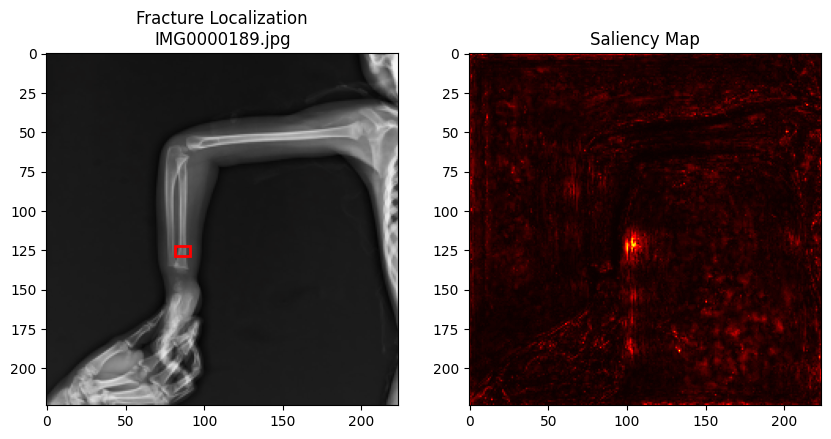

In [21]:
dataset = FracturedDataset(
    img_dir="/kaggle/working/fracatlas/fractured/img",
    ann_dir="/kaggle/working/fracatlas/fractured/ann",
    transform=transform
)

# Example: visualize saliency + fracture box
show_saliency_with_box(model, dataset, idx=15, device='cuda')